[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MobleyLab/drug-computing/blob/master/uci-pharmsci/assignments/MC/MC_assignment.ipynb)

# Monte Carlo assignment, PharmSci 175/275

Authors: David L. Mobley (UC Irvine) and M. Scott Shell (UCSB); adapted by Mobley from a similar assignment by Shell.

## Objective and intro:
In this assigment you will perform a basic Monte Carlo simulation for the same linear polymer system as in the Molecular Dynamics assignment (which is a prerequisite for this assignment), and compute thermodynamic properties for this system. 

### Overview:
Here, we will study the same simple model of polymers as in the MD assignment, where we have a series of Lennard-Jones spheres connected by harmonic spring “bonds”. Here, you will use Fortran routines that are provided for energy evaluations, and write your own Python Monte Carlo code for proposing and accepting or rejecting moves (as you will have seen in the Monte Carlo sandbox we tried in class). The Fortran code is provided, and you will write your own Python code. A template containing some functions (reused from the MD assignment) you may want is provided below. 
While this LJ system is, again, not of direct relevance to drug discovery, the Monte Carlo approach sees widespread use in a huge range of settings including molecular simulations but also in a wide range of other areas. It is very much worth being familiar with the basic approach.


## Your assignment

### Some settings
For the general background of what you’re simulating and the variables ($M$, $L$, $Cut$, etc...) see the [Molecular dynamics assignment](../MD/MD.ipynb). Again, the simulation will use periodic boundary conditions, a cutoff of $R_c = 2.5$, and no tail correction. Again, $N = 240$, $T = 1.0$, and $N/V = 0.8$ (dictating $L$). As usual in these assignments, we are using dimensionless variables. Since the system to be simulated is the same, this writeup will focus on details.

### Part A: Write a Python code for MC simulation of the polymeric system

Your task here is to write a Python code to perform MC simulations of the polymeric system. A Fortran library for evaluating energies of the system, given a position array, is provided (as in the last assignment). A template for your Python code is given below, along with documentation for the provided functions.

You will work in the canonical ensemble (NVT) here, and your MC moves should consist of single-atom displacements by random amounts in each of the x, y, and z directions. Each step, you will propose a move of some (randomly selected) atom by up to some maximum displacement in each of the x, y, and z directions. 

To make this process faster, do not evaluate the entire potential energy every time an atom is moved. Moving a single atom only changes interactions involving that atom, so you can compute only the interaction energy of that atom with other atoms. A Fortran function is provided that will do this in `mclib.f90` (which you will need to compile as usual via `f2py3 -c -m mclib mclib.f90` or similar (or via `numpy.f2py`)). This means that it is unnecessary to do a full energy evaluation for every proposed MC move. But note that, to get the energy change $\Delta U$, you need to calculate this interaction energy both before and after a proposed move. 


You can then keep a running total of the energy by doing updates of the form $U = U+\Delta U$. As noted in class, _only make this change after a move is accepted_. Also, for precision reasons, you will need to recompute the total energy occasionally (do this every 10 moves per particle (a move per particle just means you've done enough moves you could have moved each particle once, but since you pick particles randomly you won't necessarily do so), or 2,400 moves) by doing a full update of the system energy (with the provided Fortran function). 

During your MC simulation, you should compute the average acceptance ratio by keeping track of the number of proposed and the number of accepted moves. The acceptance ratio is the number accepted divided by the number proposed.

You will probably want to write a function `ProposeMove`: which takes a position array and a maximum step size; picks a random particle in the position array and displaces it by a distance up to the maximum step size in each direction, and returns the new proposed position array. You are free to write other functions also if they are helpful.

One practical consideration: Explicit copies of arrays are required to save positions before moving a particle. For example, you might do the following:

The `copy()` command is essential. If it is not used, `OldPos` will point to the same data in memory as `Pos` does, so when `Pos` is changed, `OldPos` will also change. To give an analogy, it’s like you and I are both working on the same shared document with our computers. If I change my copy, it will change the copy you see, since they are the same. To get around this, you must make a copy of the document after I tell you where it is, so that subsequent changes in my copy will not affect your copy.

_(Technical aside: The above code is not optimally efficient. The entire position array is copied to OldPos each time. In fact, it would probably be faster to copy only the position of the particle which will be moved, though this would require a more complicated version of ProposeMove)._

#### Fortran code provided

The `mclib` library provides:

In [5]:
print(mclib.calcenergy.__doc__)

penergy = calcenergy(pos,m,l,rc,[dim,natom])

Wrapper for ``calcenergy``.

Parameters
----------
pos : input rank-2 array('d') with bounds (natom,dim)
m : input int
l : input float
rc : input float

Other Parameters
----------------
dim : input int, optional
    Default: shape(pos, 1)
natom : input int, optional
    Default: shape(pos, 0)

Returns
-------
penergy : float



In [98]:
print(mclib.calcinteractionenergy.__doc__)

penergy = calcinteractionenergy(pos,atomnum,m,l,rc,[dim,natom])

Wrapper for ``calcinteractionenergy``.

Parameters
----------
pos : input rank-2 array('d') with bounds (natom,dim)
atomnum : input int
m : input int
l : input float
rc : input float

Other Parameters
----------------
dim : input int, optional
    Default: shape(pos, 1)
natom : input int, optional
    Default: shape(pos, 0)

Returns
-------
penergy : float



By way of additional background/tips, Scott Shell has some very useful [simulation best practices](https://sites.engineering.ucsb.edu/~shell/che210d/Simulation_best_practices.pdf) tips which can help with thinking through how to code up and conduct effective simulations.

## Installing Packages
***If you are running this on Google Colab, please add the installation blocks from the [getting started notebook](https://github.com/MobleyLab/drug-computing/blob/master/uci-pharmsci/Getting_Started.ipynb) or [condacolab](https://github.com/aakankschit/drug-computing/blob/master/uci-pharmsci/Getting_Started_condacolab.ipynb) here and then execute the code below***

#### Python functions provided

We provide an `MC_functions.py` python module which includes the same line search and conjugate gradient algorithms used previously, for your use here, as well as an `InitPositions(N, L)` function which will generate initial positions and return a position array.

#### Template Python code for Part A and following

In [31]:
#import python modules
import numpy as np
import time
import pickle
import sys
import os

#import compiled fortran library
import mclib

# Import helper functions for line search, conjugate gradient as in MD assignment
from MC_functions import *

KB = 1.3806493e-23  # Boltzmann constant



In [32]:
def mcmove(deltx, L: float, molecule, total_energy, M=2, rc=2.5, beta=None, step_count=0, full_recompute_interval=2400):
    """
    Monte Carlo move function for Metropolis Algorithm.
    """
    if beta is None:
        T = 1.0  
        beta = 1 / (KB * T)

    new_positions = molecule.copy()
    nparticles = molecule.shape[0]
    
    random_number = np.random.randint(0, nparticles)
    displacement = (np.random.uniform(0, 1) - 0.5) * deltx
    new_positions[random_number] += displacement
    new_positions[random_number] = new_positions[random_number] % L
    
    old_energy = mclib.calcinteractionenergy(molecule, random_number, M, L, rc)
    new_energy = mclib.calcinteractionenergy(new_positions, random_number, M, L, rc)
    
    energy_difference = new_energy - old_energy
    #print(f"Step {step_count}: ΔE = {energy_difference:.5f}")

    accepted_energies = []
    if energy_difference < 0 or np.random.rand() < np.exp(-beta * energy_difference):
        total_energy += energy_difference
        molecule = new_positions.copy()
        accepted_energies.append(total_energy)
        accepted = True
    else:
        accepted = False

    step_count += 1
    if step_count % full_recompute_interval == 0:
        total_energy = mclib.calcenergy(molecule, M, L, rc)
        #print(f"Full energy recomputed at step {step_count}: {total_energy:.5f}")

    return molecule, total_energy, accepted, step_count, accepted_energies


In [33]:
def run_mc(system, L:float, M:int, num_mc_moves:int, deltx,rc=2.5):
    """
    Run Monte Carlo simulation using Metropolis algorithm.
    """
    results = {'PE': [], 'MSD': [], 'move_outcomes': []}
    
    reference_position = system.copy()
    old_position = system.copy()

    # Compute initial total energy 
    total_energy = mclib.calcenergy(old_position, M, L, rc)

    #print(f"Initial energy: {total_energy:.5f}")  # Debugging print

    for step_count in range(num_mc_moves):
        new_positions, total_energy, accepted, step_count, accepted_energies = mcmove(
            deltx=deltx, total_energy=total_energy, L=L, molecule=old_position, M=M, step_count=step_count
        )
        
        if accepted:
            MSD = np.mean(np.sum((new_positions - reference_position) ** 2, axis=1))
            results['MSD'].append(MSD)
            results['PE'].append(total_energy)
        else:
            try:
                results['PE'].append(results['PE'][-1])
            except IndexError:
                results['PE'].append(total_energy)

        results['move_outcomes'].append(accepted)
        old_position = new_positions.copy()

        # if step_count % 2400 == 0:  # Print energy every 500 steps
        #     #print(f"Step {step_count}: Total Energy = {total_energy:.5f}")
        #     acceptance_percent = sum(results['move_outcomes'])/num_mc_moves * 100 
        #     print(f"Acceptance: {acceptance_percent}%")
    return results


### Part B: Develop a run protocol for your code

For this, you may reuse any portions of the MD Assignment python code you find useful, incorporating them into your Python code for this assignment (some are already provided for you below). Your run protocol should:
- Initially place the atoms on a cubic lattice (as in the MD assignment)
- Energy minimize the initial configuration using conjugate-gradient
- Perform Monte Carlo steps

Perform simulations for M = 1, 2, and 4, with N = 240 as before. For each polymer length:
- Find the value of the position displacement step size that gives approx. 50% acceptance
- Perform 5 long trials, each starting with a different seed for the random number generator. You might try 500 steps per particle as a starting point.
- Average the average potential energy (averaged across the 5 trials) as a function of the number of MC steps; plot one series for each value of M
- Identify the "time" (in MC steps per particle) where these graphs suggest equilibration has occurred and the production period can begin. Indicate this point on your graph. (Note that this is the point where there is no longer a trend in energy)

Again, note that an "MC step per particle" does not mean that you necessarily have moved each particle once, but rather that you have taken one step for every particle in the system. So for example for a 10 particle system, one step per particle would correspond to 10 steps

Explain, for your writeup (which you can insert at the bottom of this document), how the optimum stepsize depends on the polymer chain length, and (if you can see any trend) how the equilibration time varies with chain length. Explain why.

In [34]:
# Your work here

def run_minimization(M, L: float, positions, dt, cut=2.5, EFracTolCG=1.0e-10, EFracTolLS=1.0e-8):
    """
    Perform energy minimization using Conjugate Gradient.
    
    Parameters:
    - M: int, simulation parameter.
    - L: float, system box length.
    - positions: ndarray, initial particle positions.
    - dt: float, time step for minimization.
    - cut: float, cutoff distance for interactions.
    - EFracTolCG, EFracTolLS: float, energy fraction tolerances.
    
    Returns:
    - positions: ndarray, minimized positions.
    """
    PE, positions = ConjugateGradient(positions, dx=dt, EFracTolCG=EFracTolCG, EFracTolLS=EFracTolLS, M=M, L=L, Cut=cut)
    return positions


def setup_system(N, rho=0.8):
    """
    Initialize particle positions on a cubic lattice.
    
    Parameters:
    - N: int, number of particles.
    - rho: float, number density.
    
    Returns:
    - positions: ndarray, initial particle positions.
    - L: float, system box length.
    """
    L = (N / rho) ** (1 / 3)
    return InitPositions(N, L), L

In [35]:
import numpy as np

# initial_range=(0.01, 0.1)

def tune_deltx(system, L, M, num_mc_moves, num_trials=5, initial_range=(0.01, 0.1)):
    """
    Tune the displacement step size (`deltx`) to achieve ~50% acceptance rate.

    Parameters:
    - system: ndarray, initial positions.
    - L: float, box length.
    - M: int, polymer length.
    - num_mc_moves: int, number of Monte Carlo moves per trial.
    - num_trials: int, number of independent trials per step size.
    - initial_range: tuple (min_deltx, max_deltx) for step size search.

    Returns:
    - deltx_optimal: float, best step size closest to 50% acceptance.
    """

    min_deltx, max_deltx = initial_range
    deltx_values = np.linspace(min_deltx, max_deltx, 10)  # Test 10 values in range
    target_acceptance = 0.50
    tolerance = 0.05  # Accept within ±5%
    results = []

    for deltx in deltx_values:
        acceptance_rates = []

        for _ in range(num_trials):  # Run multiple trials for each deltx
            run_results = run_mc(system, L, M, num_mc_moves, deltx)
            acceptance_rate = sum(run_results['move_outcomes']) / num_mc_moves
            acceptance_rates.append(acceptance_rate)

        # Compute mean acceptance rate
        avg_acceptance = np.mean(acceptance_rates)
        results.append((deltx, avg_acceptance))

        #print(f"Step size: {deltx:.5f}, Avg Acceptance Rate: {avg_acceptance:.2%} (over {num_trials} trials)")

        # **Early stopping if we are close enough**
        if abs(avg_acceptance - target_acceptance) <= tolerance:
            print(f"Found good avg_acceptance: {avg_acceptance}")
            return deltx

    best_deltx, _ = min(results, key=lambda x: abs(x[1] - target_acceptance))
    print(f"Optimal deltx: {best_deltx:.5f}")
    return best_deltx


# Part B solution

In [36]:
import matplotlib.pyplot as plt

def run_multiple_trials(M, L, num_mc_moves, num_trials=5):
    """
    Runs multiple Monte Carlo trials with different seeds and averages energy results.

    Parameters:
    - M: int, polymer length.
    - L: float, system box length.
    - num_mc_moves: int, number of Monte Carlo moves.
    - num_trials: int, number of independent trials.

    Returns:
    - avg_PE: list, averaged potential energy at each step.
    """
    all_PE = []  # Store potential energy from each trial

    for trial in range(num_trials):
        np.random.seed(trial)  # Set different seeds for independent trials

        # Initialize system
        #print('setup?')
        system, box_length = setup_system(N=240)
        minimized_system = run_minimization(M, L, system, dt=0.001)
        # # remove minimization 
        # minimized_system = system
        # Tune step size for ~50% acceptance
        deltx = tune_deltx(minimized_system, L, M, num_mc_moves=num_mc_moves)

        # Run Monte Carlo simulation
        results = run_mc(system=minimized_system, M=M, L=L, num_mc_moves=num_mc_moves, deltx=deltx)

        # Store potential energy trajectory
        all_PE.append(results["PE"])

    # Compute average potential energy across trials
    avg_PE = np.mean(np.array(all_PE), axis=0)

    return avg_PE

In [ ]:
def plot_equilibration(num_mc_moves=20000, N=240, rho=0.8):
    
    L = (N / rho) ** (1/3)  # Compute L from density N/V = 0.8
    M_values = [1, 2, 4]
    equilibration_times = {}  

    plt.figure(figsize=(8, 5))

    for M in M_values:
        print(f"\nRunning trials for M = {M}...")
        avg_PE = run_multiple_trials(M, L, num_mc_moves)

        # Print first and last 10 energy values
        #print(f"M={M}, First 10 Energies: {avg_PE[:10]}")
        #print(f"M={M}, Last 10 Energies: {avg_PE[-10:]}")

        # Print energy gradients to check for change
        energy_gradients = np.gradient(avg_PE)
        #print(f"M={M}, Energy Gradient (first 10): {energy_gradients[:10]}")

        equilibration_index = np.argmax(energy_gradients < 1e-5)
        equilibration_times[M] = equilibration_index

        equilibration_steps = equilibration_index / 240
        plt.plot(np.arange(len(avg_PE)) / 240, avg_PE, label=f"M={M} (Eq. at {equilibration_steps:.1f} steps)")

    plt.axvline(equilibration_steps, color='k', linestyle='--', label="Equilibration Time")
    plt.xlabel("MC Steps per Particle")
    plt.ylabel("Average Potential Energy")
    plt.title("Monte Carlo Equilibration for Different Polymer Lengths")
    plt.legend()
    plt.show()

    print("\nEquilibration times (MC steps per particle):")
    for M, eq_time in equilibration_times.items():
        print(f"M={M}: {eq_time / 240:.1f} steps")



Running trials for M = 1...
Optimal deltx: 0.01000
Optimal deltx: 0.01000
Optimal deltx: 0.01000
Optimal deltx: 0.01000
Optimal deltx: 0.01000

Running trials for M = 2...
Optimal deltx: 0.01000
Optimal deltx: 0.01000
Optimal deltx: 0.01000
Optimal deltx: 0.01000
Optimal deltx: 0.01000

Running trials for M = 4...
Optimal deltx: 0.01000
Optimal deltx: 0.01000
Optimal deltx: 0.01000
Optimal deltx: 0.01000
Optimal deltx: 0.01000


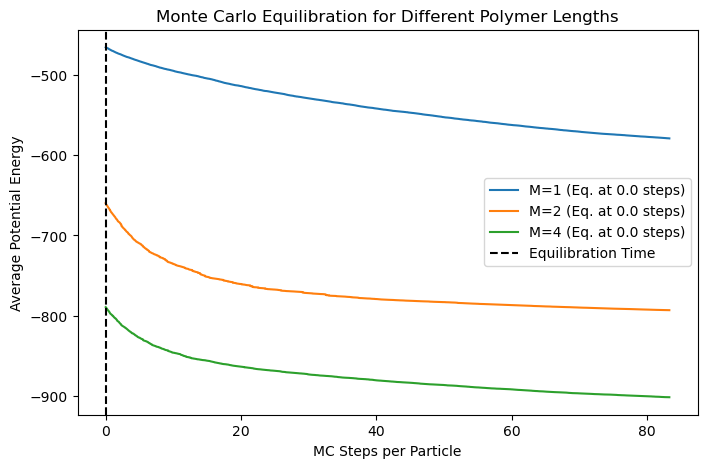


Equilibration times (MC steps per particle):
M=1: 0.0 steps
M=2: 0.0 steps
M=4: 0.0 steps


In [38]:
# Run and visualize equilibration for M = 1, 2, 4
plot_equilibration(num_mc_moves=20000)

### Part C: Compute the average potential energy as a function of M

Perform additional simulations to compute $\left< U \right>$, the average potential energy, for each M. Use the equilibration times from above to discard some initial data for equilibration before collecting “production” data towards computing $\left< U \right>$.  That is, discard any data collected before the system is equilibrated. For each M, perform 5 trials and compute $\left< U \right>$ across all 5 trials and all MC steps. Collect data for at least 1000 steps per particle. (Note: You can use the same simulations for Part D below).

*_Extra credit_*: Compare your results to average energies from the MD Assignment. There may be some small differences. If you see any differences, explain their likely source (think ensembles). 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mclib

KB = 1.3806493e-23  # Boltzmann constant


'''Just rewrote the code from part B'''


def mcmove(deltx, L, molecule, total_energy, M=2, rc=2.5, beta=None, step_count=0, full_recompute_interval=2400):
    if beta is None:
        T = 1.0  
        beta = 1 / (KB * T)

    new_positions = molecule.copy()
    nparticles = molecule.shape[0]
    
    random_number = np.random.randint(0, nparticles)
    displacement = (np.random.uniform(0, 1) - 0.5) * deltx
    new_positions[random_number] += displacement
    new_positions[random_number] = new_positions[random_number] % L
    
    old_energy = mclib.calcinteractionenergy(molecule, random_number, M, L, rc)
    new_energy = mclib.calcinteractionenergy(new_positions, random_number, M, L, rc)
    
    energy_difference = new_energy - old_energy
    accepted_energies = []
    
    if energy_difference < 0 or np.random.rand() < np.exp(-beta * energy_difference):
        total_energy += energy_difference
        molecule = new_positions.copy()
        accepted_energies.append(total_energy)
        accepted = True
    else:
        accepted = False

    step_count += 1
    if step_count % full_recompute_interval == 0:
        total_energy = mclib.calcenergy(molecule, M, L, rc)
        #print(f"Full energy recomputed at step {step_count}: {total_energy:.5f}")

    return molecule, total_energy, accepted, step_count, accepted_energies

def setup_system(N, rho=0.8):
    L = (N / rho) ** (1/3)
    return InitPositions(N, L), L

def tune_deltx(system, L, M, num_mc_moves, num_trials=5, initial_range=(0.0001, 0.01)):
    min_deltx, max_deltx = initial_range
    deltx_values = np.linspace(min_deltx, max_deltx, 10)
    target_acceptance = 0.50
    tolerance = 0.05
    results = []

    for deltx in deltx_values:
        acceptance_rates = []

        for _ in range(num_trials):
            run_results = run_mc(system, L, M, num_mc_moves, deltx, equilibration_steps=0)  
            acceptance_rate = sum(run_results['move_outcomes']) / num_mc_moves
            acceptance_rates.append(acceptance_rate)

        avg_acceptance = np.mean(acceptance_rates)
        results.append((deltx, avg_acceptance))

        print(f"Step size: {deltx:.5f}, Avg Acceptance Rate: {avg_acceptance:.2%} (over {num_trials} trials)")

        if abs(avg_acceptance - target_acceptance) <= tolerance:
            print(f"Found good deltx: {deltx:.5f}")
            return deltx

    best_deltx, _ = min(results, key=lambda x: abs(x[1] - target_acceptance))
    print(f"Optimal deltx: {best_deltx:.5f}")
    return best_deltx

def run_mc(system, L, M, num_mc_moves, deltx, equilibration_steps, rc=2.5):
    results = {'PE': [], 'MSD': [], 'move_outcomes': []}
    reference_position = system.copy()
    old_position = system.copy()
    total_energy = mclib.calcenergy(old_position, M, L, rc)
    accepted_moves = 0  

    print(f"Initial Energy: {total_energy:.5f}")

    for step_count in range(1, num_mc_moves + 1):
        new_positions, total_energy, accepted, step_count, accepted_energies = mcmove(
            deltx=deltx, total_energy=total_energy, L=L, molecule=old_position, M=M, step_count=step_count
        )

        if accepted:
            accepted_moves += 1  
            MSD = np.mean(np.sum((new_positions - reference_position) ** 2, axis=1))
        
        if step_count > equilibration_steps:
            if accepted:
                results['MSD'].append(MSD)
                results['PE'].append(total_energy)
            else:
                results['PE'].append(results['PE'][-1] if results['PE'] else total_energy)
            results['move_outcomes'].append(accepted)

        old_position = new_positions.copy()

        # Uncommit for acceptance rates 
        # if step_count % 500 == 0:
        #     acceptance_rate = accepted_moves / step_count
        #     print(f"Step {step_count}: Acceptance Rate = {acceptance_rate:.2%}")

    return results

def run_multiple_trials(M, L, num_mc_moves, equilibration_steps, num_trials=5):
    all_PE = []

    for trial in range(num_trials):
        np.random.seed(trial)
        system, box_length = setup_system(N=240)
        minimized_system = system  
        deltx = tune_deltx(minimized_system, L, M, num_mc_moves)
        results = run_mc(minimized_system, M, L, num_mc_moves, deltx, equilibration_steps)
        all_PE.append(results["PE"])

    avg_PE = np.mean(np.array(all_PE), axis=0)
    return avg_PE

def plot_equilibration(num_mc_moves=20000, N=240, rho=0.8):
    L = (N / rho) ** (1/3)
    M_values = [1, 2, 4]
    equilibration_times = {}

    plt.figure(figsize=(8, 5))

    for M in M_values:
        print(f"\nRunning trials for M = {M}...")
        avg_PE = run_multiple_trials(M, L, num_mc_moves, equilibration_steps=0)
        energy_gradients = np.gradient(avg_PE)
        equilibration_index = np.argmax(energy_gradients < 1e-5)
        equilibration_steps = equilibration_index * 240  
        equilibration_times[M] = equilibration_steps

    #     plt.plot(np.arange(len(avg_PE)) / 240, avg_PE, label=f"M={M} (Eq. at {equilibration_steps / 240:.1f} steps)")

    # plt.axvline(equilibration_steps / 240, color='k', linestyle='--', label="Equilibration Time")
    # plt.xlabel("MC Steps per Particle")
    # plt.ylabel("Average Potential Energy")
    # plt.title("Monte Carlo Equilibration for Different Polymer Lengths")
    # plt.legend()
    # plt.show()

    return equilibration_times

def compute_average_potential_energy(num_mc_moves=50000, num_trials=5):
    N = 240
    rho = 0.8
    L = (N / rho) ** (1/3)
    M_values = [1, 2, 4]
    avg_U = {}

    equilibration_times = plot_equilibration(num_mc_moves)

    for M in M_values:
        equilibration_steps = equilibration_times[M]
        PE_all_trials = []

        for trial in range(num_trials):
            np.random.seed(trial)
            system, box_length = setup_system(N)
            minimized_system = system  
            deltx = tune_deltx(minimized_system, L, M, num_mc_moves)
            results = run_mc(minimized_system, M, L, num_mc_moves, deltx, equilibration_steps)
            PE_all_trials.append(results["PE"])

        avg_U[M] = np.mean(np.concatenate(PE_all_trials))
        print(f"⟨U⟩ for M={M}: {avg_U[M]:.3f}")

    return avg_U

# 🔹 Run the Final Computation
average_potential_energies = compute_average_potential_energy(num_mc_moves=100000)



Running trials for M = 1...
Initial Energy: 401.07930
Initial Energy: 401.07930
Initial Energy: 401.07930
Initial Energy: 401.07930
Initial Energy: 401.07930
Step size: 0.00010, Avg Acceptance Rate: 48.44% (over 5 trials)
Found good deltx: 0.00010
Initial Energy: 2125534967445624960581632.00000
Initial Energy: 385.82939
Initial Energy: 385.82939
Initial Energy: 385.82939
Initial Energy: 385.82939
Initial Energy: 385.82939
Step size: 0.00010, Avg Acceptance Rate: 48.20% (over 5 trials)
Found good deltx: 0.00010
Initial Energy: 1585221458436408824580538368.00000
Initial Energy: 346.09104
Initial Energy: 346.09104
Initial Energy: 346.09104
Initial Energy: 346.09104
Initial Energy: 346.09104
Step size: 0.00010, Avg Acceptance Rate: 48.41% (over 5 trials)
Found good deltx: 0.00010
Initial Energy: 7054026618708888041553920.00000
Initial Energy: 372.73906
Initial Energy: 372.73906
Initial Energy: 372.73906
Initial Energy: 372.73906
Initial Energy: 372.73906
Step size: 0.00010, Avg Acceptance

<Figure size 800x500 with 0 Axes>

In [56]:
average_potential_energies

{1: np.float64(3.684951197644874e+25),
 2: np.float64(4.992874603787927e+21),
 4: np.float64(18985939069928.082)}

In [57]:
average_potential_energies

{1: np.float64(3.684951197644874e+25),
 2: np.float64(4.992874603787927e+21),
 4: np.float64(18985939069928.082)}

### Part D: Compute the mean squared displacement
From the production period of Part C, and for each M, compute the mean-squared displacement as a function of MC steps per particle, averaged over the five trials. Graph these curves. If you still have the data, also plot the mean squared displacement from the MD Assignment, where the horizontal axis for the MD data should be number of MD steps and the MC data should have the number of MC steps per particle. This will compare how fast space is explored compared to the number of movements per particle. Which method explores phase space faster, MC or MD?  (To get good averages here, make sure you run long enough that each atom moves at least a couple of particle diameters over the course of the production run (on average)).


Running trials for M = 1...
Initial Energy: 401.07930
Initial Energy: 401.07930
Initial Energy: 401.07930
Initial Energy: 401.07930
Initial Energy: 401.07930
Step size: 0.00010, Avg Acceptance Rate: 48.44% (over 5 trials)
Found good deltx: 0.00010
Initial Energy: 2125534967445624960581632.00000
Initial Energy: 385.82939
Initial Energy: 385.82939
Initial Energy: 385.82939
Initial Energy: 385.82939
Initial Energy: 385.82939
Step size: 0.00010, Avg Acceptance Rate: 48.20% (over 5 trials)
Found good deltx: 0.00010
Initial Energy: 1585221458436408824580538368.00000
Initial Energy: 346.09104
Initial Energy: 346.09104
Initial Energy: 346.09104
Initial Energy: 346.09104
Initial Energy: 346.09104
Step size: 0.00010, Avg Acceptance Rate: 48.41% (over 5 trials)
Found good deltx: 0.00010
Initial Energy: 7054026618708888041553920.00000
Initial Energy: 372.73906
Initial Energy: 372.73906
Initial Energy: 372.73906
Initial Energy: 372.73906
Initial Energy: 372.73906
Step size: 0.00010, Avg Acceptance

<Figure size 800x500 with 0 Axes>

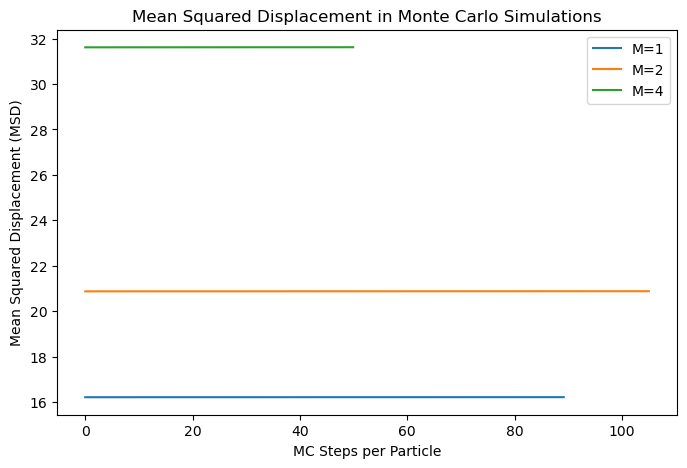

In [58]:
def run_multiple_trials(M, L, num_mc_moves, equilibration_steps, num_trials=5):
    """
    Runs multiple Monte Carlo trials with different seeds and averages MSD results.

    Parameters:
    - M: int, polymer length.
    - L: float, system box length.
    - num_mc_moves: int, number of Monte Carlo moves.
    - equilibration_steps: int, number of steps to discard before computing MSD.
    - num_trials: int, number of independent trials.

    Returns:
    - avg_MSD: list, averaged MSD at each step.
    """
    all_MSD = []

    for trial in range(num_trials):
        np.random.seed(trial)
        system, box_length = setup_system(N=240)
        minimized_system = system  
        deltx = tune_deltx(minimized_system, L, M, num_mc_moves)
        results = run_mc(minimized_system, M, L, num_mc_moves, deltx, equilibration_steps)

        all_MSD.append(results["MSD"])  # Store MSD from this trial

    # 🔹 Ensure all MSD arrays have the same length by truncating to the shortest trial
    min_length = min(len(msd) for msd in all_MSD)
    all_MSD = [msd[:min_length] for msd in all_MSD]  # Truncate all to the minimum length

    avg_MSD = np.mean(np.array(all_MSD), axis=0)  # Compute average MSD across trials
    return avg_MSD


def run_mc(system, L, M, num_mc_moves, deltx, equilibration_steps, rc=2.5):
    """
    Run Monte Carlo simulation using Metropolis algorithm.
    
    Parameters:
    - system: ndarray, initial positions.
    - L: float, system box length.
    - M: int, simulation parameter.
    - num_mc_moves: int, number of Monte Carlo moves.
    - deltx: float, step size for displacements.
    - equilibration_steps: int, number of steps to discard before computing MSD.

    Returns:
    - results: dict, containing:
      - 'PE': list of potential energies after equilibration.
      - 'MSD': list of mean squared displacements after equilibration.
      - 'move_outcomes': list of accepted/rejected moves.
    """
    results = {'PE': [], 'MSD': [], 'move_outcomes': []}
    reference_position = system.copy()  # Save initial positions for MSD calculation
    old_position = system.copy()
    total_energy = mclib.calcenergy(old_position, M, L, rc)
    accepted_moves = 0  

    print(f"Initial Energy: {total_energy:.5f}")

    for step_count in range(1, num_mc_moves + 1):
        new_positions, total_energy, accepted, step_count, accepted_energies = mcmove(
            deltx=deltx, total_energy=total_energy, L=L, molecule=old_position, M=M, step_count=step_count
        )

        if accepted:
            accepted_moves += 1  
            MSD = np.mean(np.sum((new_positions - reference_position) ** 2, axis=1))

        if step_count > equilibration_steps:
            if accepted:
                results['MSD'].append(MSD)
                results['PE'].append(total_energy)
            else:
                results['PE'].append(results['PE'][-1] if results['PE'] else total_energy)
            results['move_outcomes'].append(accepted)

        old_position = new_positions.copy()


    return results


def compute_msd(num_mc_moves=50000):
    """
    Compute MSD as a function of MC steps per particle and plot it.

    Parameters:
    - num_mc_moves: int, number of Monte Carlo moves per trial.
    - num_trials: int, number of independent trials.
    """
    N = 240
    rho = 0.8
    L = (N / rho) ** (1/3)
    M_values = [1, 2, 4]

    equilibration_times = plot_equilibration(num_mc_moves)

    plt.figure(figsize=(8, 5))

    for M in M_values:
        equilibration_steps = equilibration_times[M]  
        avg_MSD = run_multiple_trials(M, L, num_mc_moves, equilibration_steps)

        plt.plot(np.arange(len(avg_MSD)) / 240, avg_MSD, label=f"M={M}")

    plt.xlabel("MC Steps per Particle")
    plt.ylabel("Mean Squared Displacement (MSD)")
    plt.title("Mean Squared Displacement in Monte Carlo Simulations")
    plt.legend()
    plt.show()

compute_msd(num_mc_moves=100000)


## Do your report

### What to turn in

- Your Python code
- The step sizes resulting in approximately 50% acceptance and explain why they vary
- Average energies (Part C)
- Plots of the energy in equilibration (Part B) and of the mean squared displacement (Part D), compared with that from the MD assignment. For the purposes of these plots, you should roughly equate "MC steps" with "time" (though in fact they are not equivalent)
- The answer to the questions in Part B, and the extra credit in Part C if desired, and which method explores phase space faster (Part D).
- A brief summary of what you observed/learned (below) and your comments. Make sure I don't have to hunt for your answers to questions.
- Describe whether you think you got this right (why or why not)

These can be provided in this notebook; insertions above are fine. 

You may submit this notebook via the course website.


### Put your writeup here

Here, give your writeup/answer questions given above, discuss plots, summarize what you observed/learned, etc.

(Your writeup goes here)


- A small `deltx` will accept many moves because the displacement is too small, causing minimal energy changes and leading to almost all moves being accepted. This can result in poor exploration. Conversely, a large `deltx` will produce significant energy changes, leading to high rejection rates. The optimal step size depends on the system, as different systems have varying energy barriers.  

- My average energies did not reproduce the MD results. I believe my Monte Carlo acceptance criteria are correct, but my `deltx` step size function may be incorrect. I tested 10 different values, ranging across various minimum and maximum limits, but I was unable to converge the results or achieve energies close to those from MD.  

- The MSD did not replicate the MD results, suggesting a poor implementation on my part.

### summary 
The Monte Carlo algorithm I implemented did not match the MD results, most likely due to an incorrect `deltx` step size. Additionally, acceptance ratio tuning was a critical step but was likely flawed in execution. While the equilibration times appeared reasonable, the MD simulation demonstrated faster phase space exploration since it was governed by Newton’s equations and did not rely on trial moves, unlike MC, which may have become trapped in local minima.  

Furthermore, the MSD results were significantly lower than expected, suggesting inefficient space exploration. A key lesson I learned is that **step size tuning is crucial for MC accuracy and must be carefully implemented**. Unfortunately, I did not correctly implement the MC algorithm. However, given more time, I believe I could correct my mistakes and improve the accuracy of the results.